## Prepearing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import shap

import colors
# load JS visualization code to notebook
shap.initjs() 

In [2]:
data_features = pd.read_hdf('/Users/OlgaKo/Desktop/from_lab14/data_features_JetHT.hdf5', "data").reset_index(drop=True)
labels = 1-pd.read_hdf('/Users/OlgaKo/Desktop/from_lab14/labels_JetHT.hdf5', 'labels').reset_index(drop=True)
sublabels = pd.read_hdf('/Users/OlgaKo/Desktop/from_lab14/data_not_f_JetHT.hdf5', "data").reset_index(drop=True)

In [3]:
data_features.shape, sublabels.shape

((162990, 2470), (162990, 20))

## some runs with given cause of anomaly

In [61]:
dict_causes = {
 273150:" [[61, 64], [66, 75]],     Ecal excluded",
 273296:" [[1, 94]],    Pixe excluded",
 273426:" [[1, 59], [64, 64], [66, 69]],inefficeincy in EE",
 273445:" [[5, 6]],  tracker off  seen by many systems",
 274142:" [[99, 100]],  pixel and tracker off",
 274157:" [[103, 534]],  EB minus has region with low efficiency",
 274282:" [[86, 88]],  tracker is off --> particle flow object are affected",
 275326:" [[1, 169]],  sistrip excl",
 275757:" [[104, 122]],  low DCS: HBHE. nothing on PF plot",
 275758:" [[1, 4]],   part of hcal not available --> JetMET reconstruction suffers",
 275764:" [[1, 31]],   pixel off",
 275766:" [[1, 23], [25, 60]],  lower tracker efficiency",
 275768:" [[1, 79]],  lower tracker efficiency",
 275769:" [[1, 22]],  pixel not in Data Acquisition",
 275781:" [[1, 29]],  EB+16, +17, +18 are excluded due to a problem with VME crateS206h",
 275783:" [[1, 1634]],  strip EXCL",
 275838:" [[1, 51]],  strip EXCL",
 275922:" [[4, 6]],  low stat",
 276064:" [[1, 22]],  hot trigger tower seen in EE-07 (high occupancy and Et TP) which cause  ~100% deadtime",
 276071:" [[1, 22]],   strip EXCL",
 276095:" [[1, 5]],   low stat",
 276237:" [[1, 5]],   ECAL, HCAL, PIXEL excluded",
 276453:" [[1, 8], [10, 125]],  EB-17 (FED 626): was excluded (because of cooling failure)",
 276455:" [[1, 401]],  strip EXCL",
 276456:" [[1, 182]],  strip EXCL",
 276457:" [[1, 19]],  sistrip not in DAQ",
 277217:" [[12, 14]],  Short collision run with strip in error in DCS and pixel in error in DAQ. For physically meaningful lumisections 33-47, the total rate is zero. L1T flags marked as bad due to this",
 277933:" [[1, 42]],  ECAL EE+09 FED 648 removed from all LS in the run because it was causing 100% dead time. EE+09 was not masked, so all LS in this run are bad",
 278309:" [[1, 10]],  EE-04 FED 607 TT disabled in LS [1-10] according to express dataset (LS# 10)",
 278821:" [[1, 33], [36, 37]],  FED652 in error, EE+04 is off",
 279028:" [[1, 17]],  strip EXCL",
 279995:" [[1, 8]],  hcal water colling issues",
 280002:" [[1, 111]],  ecal excluded",
 280006:" [[1, 68]],  EB-11 token ring missing",
 280007:" [[1, 36]],  Low voltage channel broken in EB",
 280239:" [[1, 9]],  strip EXCL",
 280241:" [[1, 11]],  strip EXCL",
 281663:" [[61, 172]],  Timing shifted by 5ns due to TCDS* problem ",
 281674:" [[1, 45]],  Timing shifted by 5ns due to TCDS* problem",
 281680:" [[1, 31]],  Timing shifted by 5ns due to TCDS* problem",
 281974:" [[79, 85]],  pixel High voltage OFF",
 282408:" [[80, 191]],  strip EXCL",
 282707:" [[79, 81]],  pixel High voltage OFF",
 282796:" [[80, 82]],  pixel High Voltage off",
 282921:" [[1, 152]],       strip EXCL"

    
}

In [5]:
indx_train = np.arange(data_features.shape[0]-int(data_features.shape[0]/5), dtype='int32')
indx_test = np.arange(data_features.shape[0]-int(data_features.shape[0]/5),data_features.shape[0], dtype='int32')

In [6]:
indx_known = sublabels[sublabels["runId"].isin(dict_causes.keys())].index.tolist()
ids_known = sublabels[['runId', 'lumiId']].iloc[indx_known]

In [7]:
indx_train_minus = [s for s in indx_train if (s not in indx_known)]

In [8]:
num_good = np.sum(labels)
num_bad = len(labels)-np.sum(labels)

weights = 0.5 / np.where(labels == 0.0, num_good, num_bad)
weights *= len(labels)

In [9]:
y_train = np.array(labels.iloc[indx_train_minus], 'float32')
y_known = np.array(labels.iloc[indx_known], 'float32')
y_test = np.array(labels.iloc[indx_test], 'float32')

X_train = np.array(data_features.iloc[indx_train_minus], 'float32')
X_known = np.array(data_features.iloc[indx_known], 'float32')
X_test = np.array(data_features.iloc[indx_test], 'float32')

weights_train = weights[indx_train_minus]
weights_test = weights[indx_test]

In [10]:
feature_names = data_features.columns

In [11]:
Muon_features = [s for s in feature_names if (s[:3] == 'qMu')]# and (s[3:7] != 'Cosm')]
Pho_features = [s for s in feature_names if s[:4] == 'qPho']
Cal_features = [s for s in feature_names if s[:4] == 'qCal']
PF_features = [s for s in feature_names if s[:3] == 'qPF']

channels_features = dict()

channels_features['muons'] = Muon_features
channels_features['photons'] = Pho_features
channels_features['PF'] = PF_features
channels_features['calo'] = Cal_features

In [12]:
num_fch = dict()
for g, fs in channels_features.items():
    num_fch[g]=len(fs)

In [13]:
num_fch

{'PF': 878, 'calo': 280, 'muons': 439, 'photons': 224}

In [14]:
vmins = []
vmaxs = []

for f in data_features.columns:
    values = data_features[f].values
    # trim the color range, but prevent the color range from collapsing
    vmin = np.nanpercentile(values, 5)
    vmax = np.nanpercentile(values, 95)
    if vmin == vmax:
        vmin = np.nanpercentile(values, 1)
        vmax = np.nanpercentile(values, 99)
        if vmin == vmax:
            vmin = np.min(values)
            vmax = np.max(values)
    vmins.append(vmin)
    vmaxs.append(vmax)

In [51]:
vmins = np.array(vmins)
vmaxs = np.array(vmaxs)

In [15]:
X_ref=X_test[np.random.choice(np.where(y_test==1)[0], size=100, replace=False)]

## train any classifier

In [16]:
import xgboost as xgb
xgb_clf  = xgb.XGBClassifier(n_estimators=80, max_depth=10, learning_rate=0.1, silent=False)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [18]:
model = xgb_clf

## SHAP to explain predictions

In [22]:
shap_values = shap.TreeExplainer(model).shap_values(X_known)
shap_ref = shap.TreeExplainer(model).shap_values(X_ref)

In [69]:
def summary_plot_custom(shap_values, features=None, feature_names=None, max_display=20,
                 vmins=None, vmaxs=None, return_oder=True,
                 axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, auto_size_plot=True):

    num_features = shap_values.shape[1]


    if sort:
        # order features by the sum of their effect magnitudes
        feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.arange(min(max_display, num_features))

        
    row_height = 0.4
    if auto_size_plot:
        pl.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    pl.axvline(x=0, color="#999999", zorder=-1)


    for pos, i in enumerate(feature_order):
        pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
        shaps = shap_values[:, i]
        values = features[:, i]


        N = len(shaps)
        nbins = 100
        quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
        inds = np.argsort(quant + np.random.randn(N) * 1e-6)
        layer = 0
        last_bin = -1
        ys = np.zeros(N)
        for ind in inds:
            if quant[ind] != last_bin:
                layer = 0
            ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
            layer += 1
            last_bin = quant[ind]
        ys *= 0.9 * (row_height / np.max(ys + 1))

        vmin=vmins[i]
        vmax=vmaxs[i]

        nan_mask = np.isnan(values)
        
        pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                   vmax=vmax, s=16, alpha=alpha, linewidth=0,
                   zorder=3, rasterized=len(shaps) > 500)
        
        
        pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                   cmap=colors.red_blue, vmin=vmin, vmax=vmax, s=16,
                   c=values[np.invert(nan_mask)], alpha=alpha, linewidth=0,
                   zorder=3, rasterized=len(shaps) > 500)



    import matplotlib.cm as cm
    m = cm.ScalarMappable(cmap=pl.get_cmap(red_blue))
    m.set_array([0, 1])
    cb = pl.colorbar(m, ticks=[0, 1], aspect=1000)
    cb.set_ticklabels(['feature value low', 'feature value high'])
    cb.set_label('feature value', size=12, labelpad=0)
    cb.ax.tick_params(labelsize=11, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
    cb.ax.set_aspect((bbox.height - 0.9) * 20)

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=13)
    pl.gca().tick_params('x', labelsize=11)
    pl.ylim(-1, len(feature_order))
    pl.xlabel('shap value', fontsize=13)
    if show:
        pl.show()
    
    if return_oder:
        return feature_order

276237 is not found
273426 is not found

(278821, ' [[1, 33], [36, 37]],  FED652 in error, EE+04 is off')

sum of features' influences from all lumis, 20 the most important

Index([u'qCCPhi5x5_0', u'qCCPhi5x5_5', u'qPFMetPhi_1', u'qCCEn5x5_5',
       u'qCCEta5x5_0', u'qCalJet1Pt_4', u'qEEenergy_3', u'qEEix_4',
       u'qESenergy_4', u'qEBchi2_1', u'qEEiy_0', u'qCalMETBEFOPhi_3',
       u'qCalMETPhi_3', u'qCalMETBEFOPhi_1', u'qPreShEn_5', u'qHBHEtime_5',
       u'qCalJet2Pt_5', u'qEBtime_3', u'qPreShEta_5', u'qPFJet8CHS1Eta_1'],
      dtype='object')

the most common features with big shap values

Index([u'qCCPhi5x5_0', u'qCCPhi5x5_5', u'qCCEn5x5_5', u'qCCEta5x5_0',
       u'qEEix_4', u'qESenergy_4', u'qEBchi2_1', u'qEEiy_0', u'qHBHEtime_5',
       u'qPreShEn_5', u'qCalJet2Pt_5', u'qPFJetEta_1', u'qPreShPhi_0',
       u'qCalJetEn_0', u'qPFJet8CHSEta_3', u'qPFJet8CHSPt_3'],
      dtype='object')

summary plot


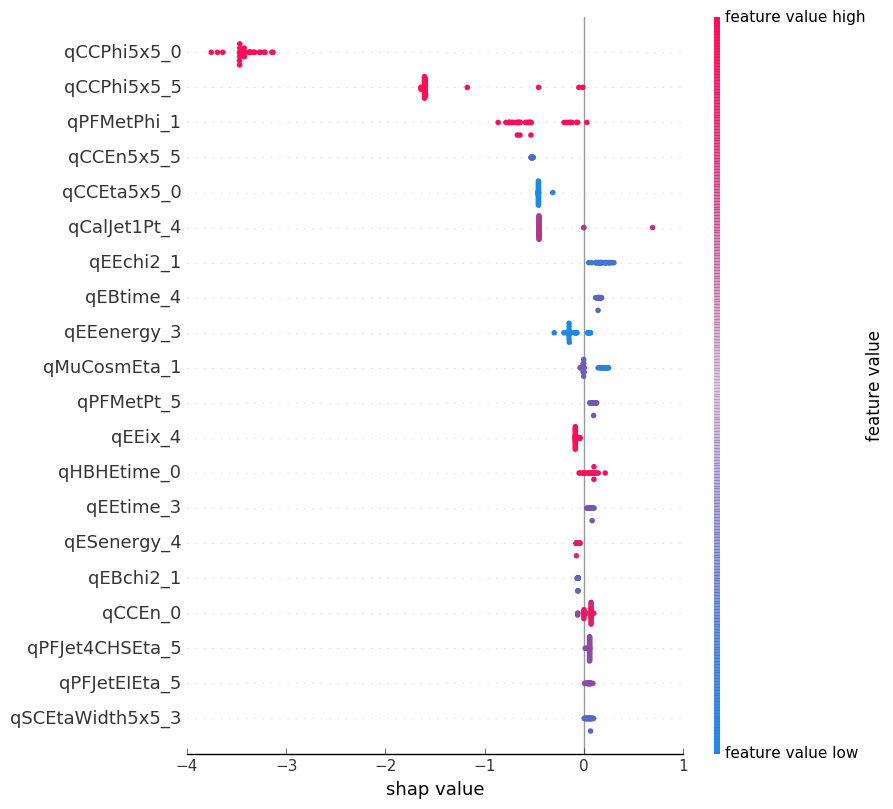

reference plot for good lumis


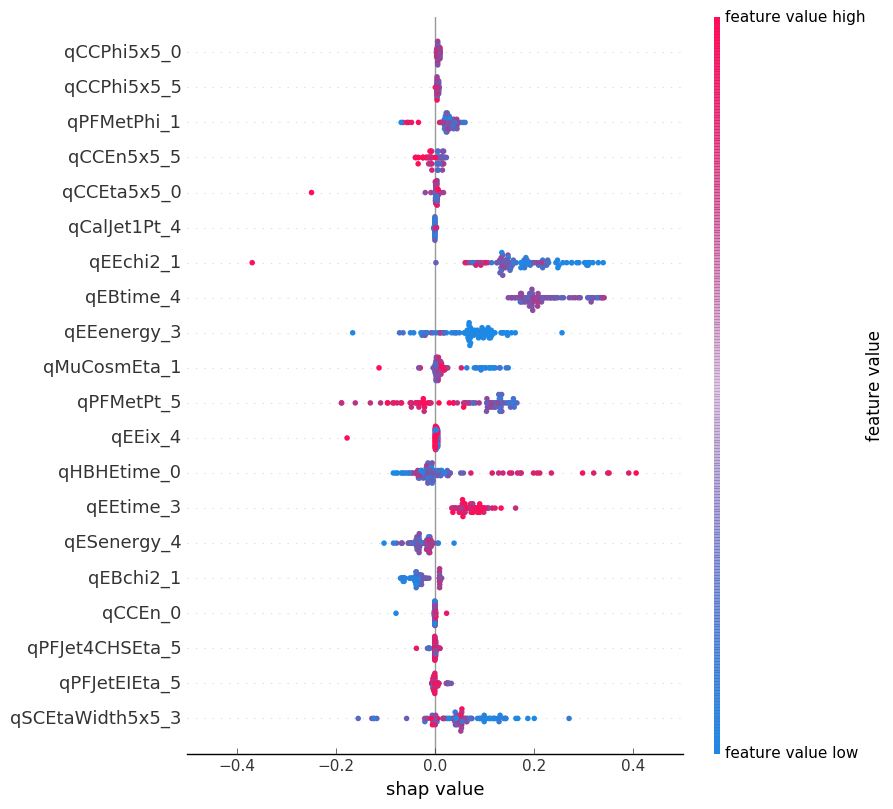

shap for channel for lumi
          PF      calo     muons   photons
0  -0.000598 -0.001788  0.000524  0.000061
1  -0.000078 -0.001764 -0.000044 -0.000226
2  -0.000517 -0.002080  0.000039  0.000312
3  -0.000260 -0.002363  0.000691  0.000301
4  -0.000585 -0.001931  0.000054  0.000038
5  -0.000113 -0.006109  0.000233  0.000277
6  -0.000584  0.002204 -0.000035 -0.000130
7   0.000008 -0.002015 -0.000227  0.000229
8  -0.000351 -0.000415  0.000072  0.000366
9  -0.000200 -0.002013  0.000267  0.000294
10 -0.000684 -0.001810  0.000517  0.000195
11 -0.000290 -0.002200  0.000354  0.000184
12 -0.000073 -0.002373  0.000368  0.000039
13  0.000456 -0.002198  0.000727  0.000094
14 -0.000196 -0.000619  0.000036  0.000231
15  0.000031 -0.002056  0.000459  0.000125
16 -0.000449 -0.001790  0.000040  0.000088
17  0.000418 -0.001797  0.000665  0.000099
18  0.000406 -0.001966  0.000693  0.000129
19 -0.000077 -0.002025  0.000089  0.000020
20 -0.000580 -0.001687  0.000720 -0.000134
21 -0.000162 -0.001762  0.00

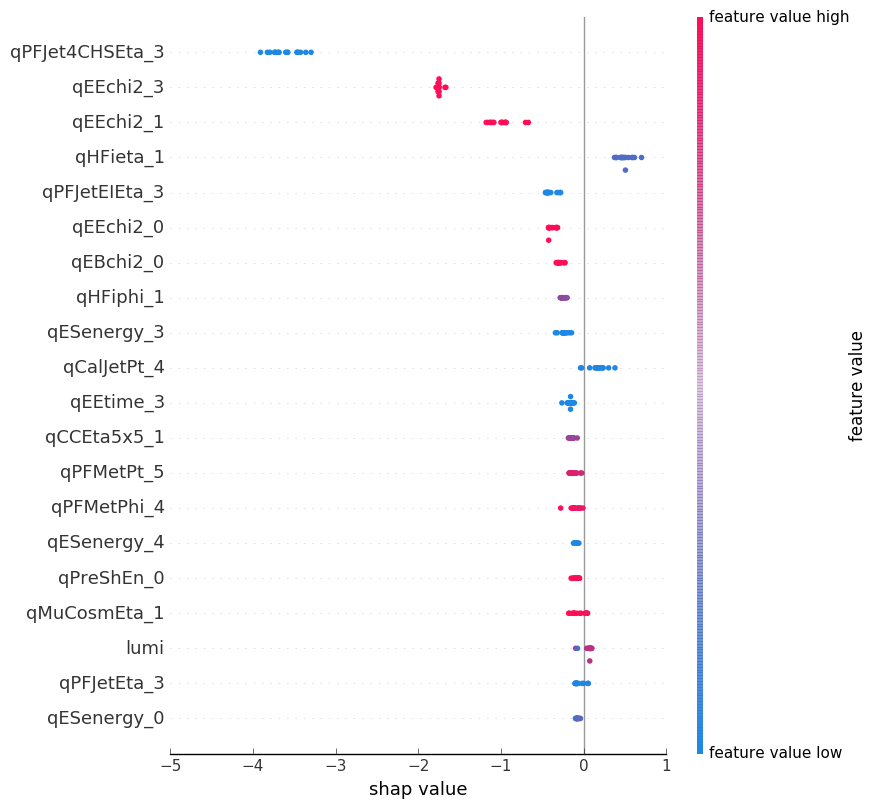

reference plot for good lumis


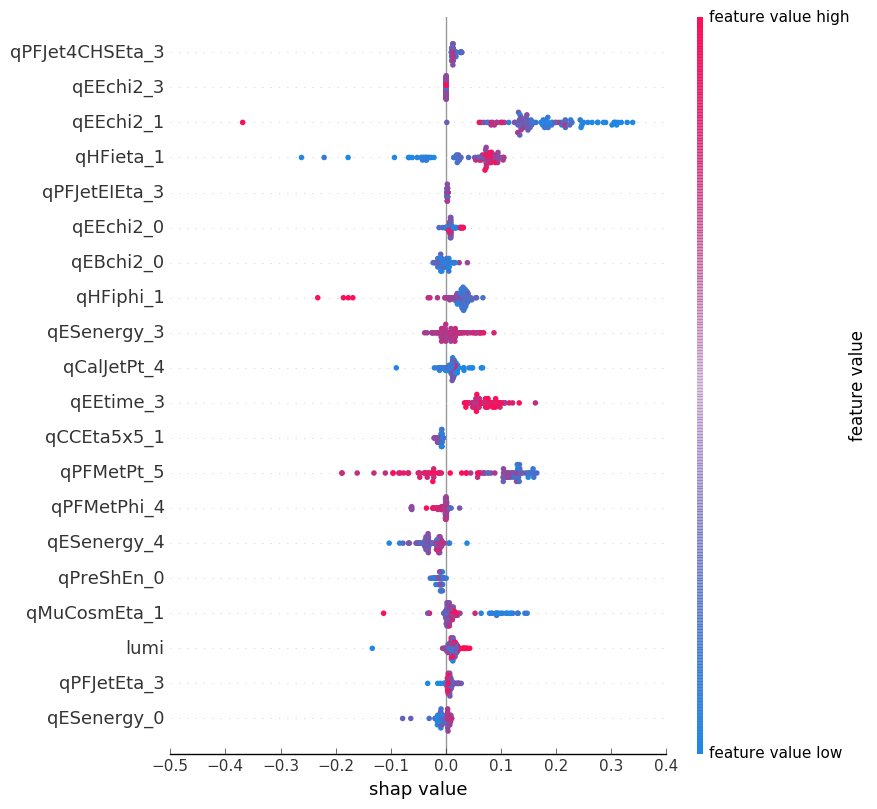

shap for channel for lumi
          PF      calo     muons   photons
0  -0.005485 -0.000995  0.000073 -0.000838
1  -0.004827  0.000368 -0.000181 -0.000726
2  -0.005052  0.000410 -0.000195 -0.000683
3  -0.004729 -0.000168  0.000102 -0.000124
4  -0.004679  0.000179 -0.000052 -0.000536
5  -0.005289  0.000420  0.000023 -0.000961
6  -0.004851  0.000445  0.000257 -0.000890
7  -0.004297  0.000198  0.000015 -0.000843
8  -0.004684  0.000245  0.000141 -0.000248
9  -0.004614  0.000361  0.000159 -0.000199
10 -0.005009 -0.000051  0.000283  0.000019
11 -0.004981  0.000356  0.000661 -0.000304
12 -0.005329  0.001099 -0.000074 -0.000666
13 -0.005405  0.000923  0.000374 -0.000823
14 -0.004767  0.000752  0.000353 -0.000311
15 -0.005052  0.001016  0.000379 -0.000259
16 -0.004907  0.000305  0.000403 -0.000431
 
shap for channel for run
PF        -0.083958
calo       0.005863
muons      0.002721
photons   -0.008822
dtype: float64
 
____________________________________________________________________________

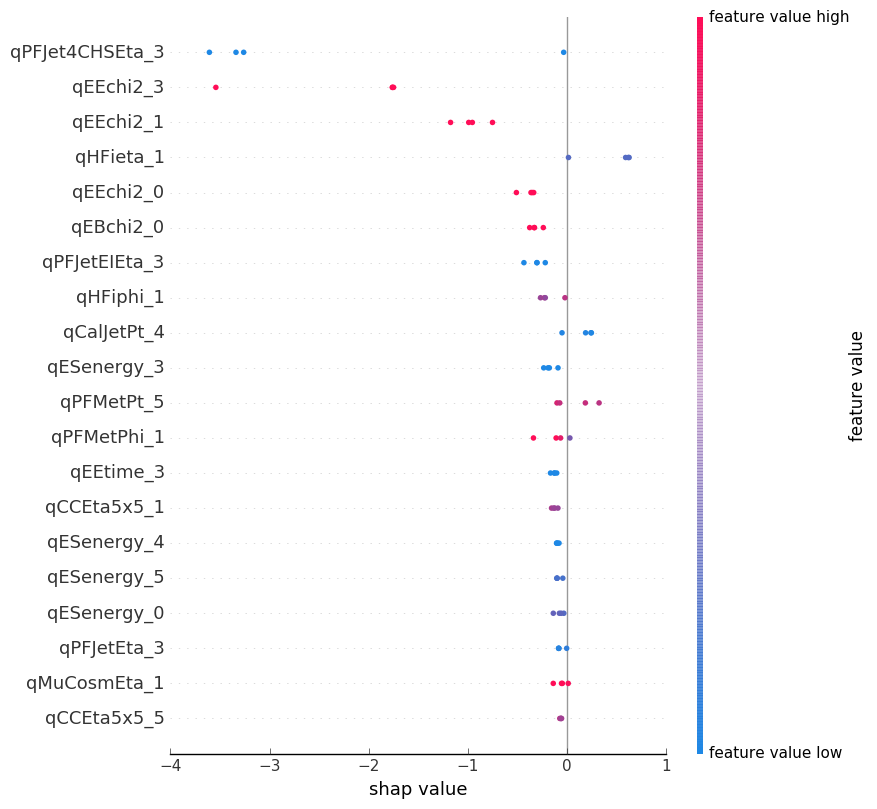

reference plot for good lumis


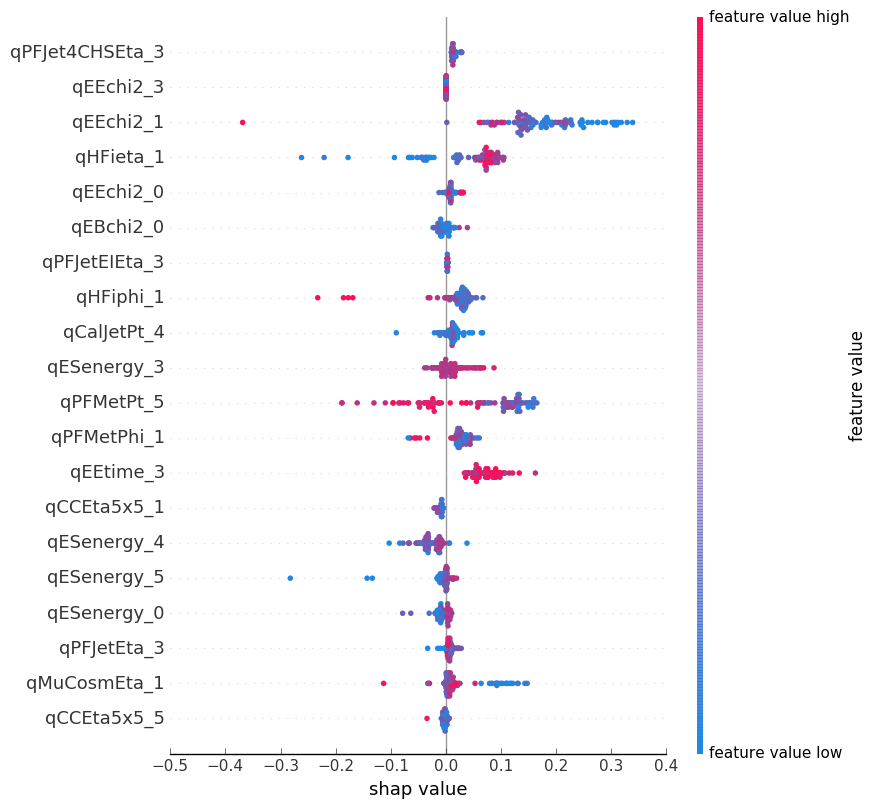

shap for channel for lumi
         PF      calo     muons   photons
0 -0.005070  0.000542  0.000347 -0.000184
1 -0.004338  0.000651 -0.000193 -0.000386
2 -0.004050  0.000890  0.000307 -0.000315
3 -0.000654 -0.000166  0.000237 -0.000834
 
shap for channel for run
PF        -0.014113
calo       0.001917
muons      0.000698
photons   -0.001719
dtype: float64
 
____________________________________________________________________________________________________

(275764, ' [[1, 31]],   pixel off')

sum of features' influences from all lumis, 20 the most important

Index([u'qEEchi2_3', u'qPFJet4CHSEta_3', u'qEEchi2_1', u'qPFMetPhi_5',
       u'qEEchi2_0', u'qEBchi2_0', u'qPFMetPhi_1', u'qPFJetEIEta_3',
       u'qESenergy_3', u'qEEtime_3', u'qHFiphi_1', u'qESenergy_4',
       u'qPFMetPhi_4', u'qCCEta5x5_1', u'qPFJetPhi_3', u'qPFMetPt_5',
       u'qPreShEn_0', u'qESenergy_0', u'qSCEta5x5_4', u'qEEenergy_4'],
      dtype='object')

the most common features with big shap values

Index([u'qEEchi2

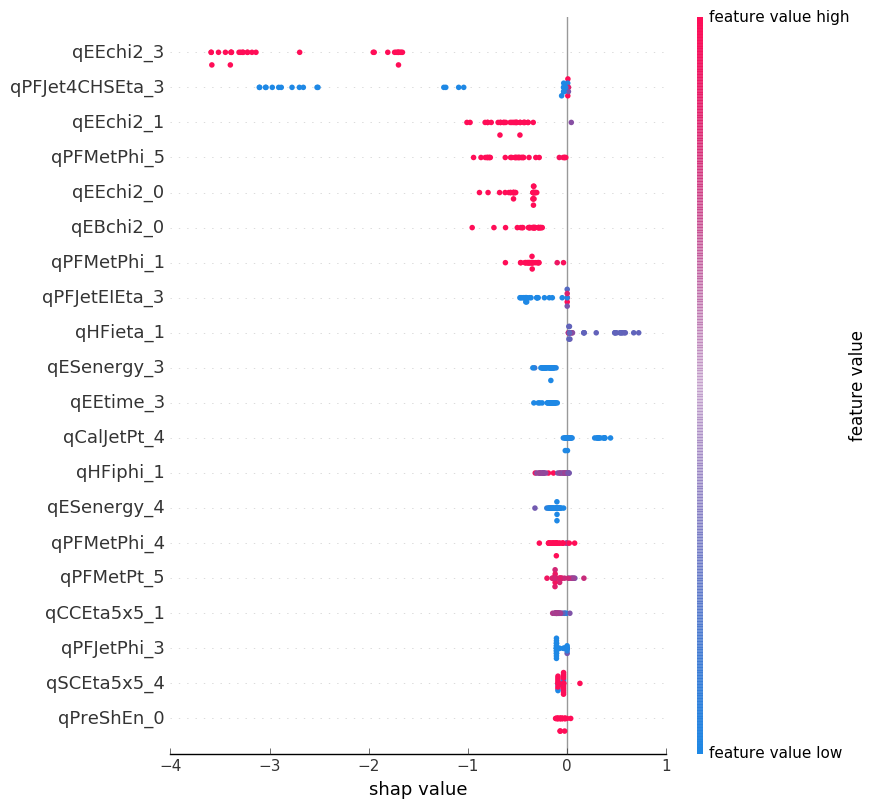

reference plot for good lumis


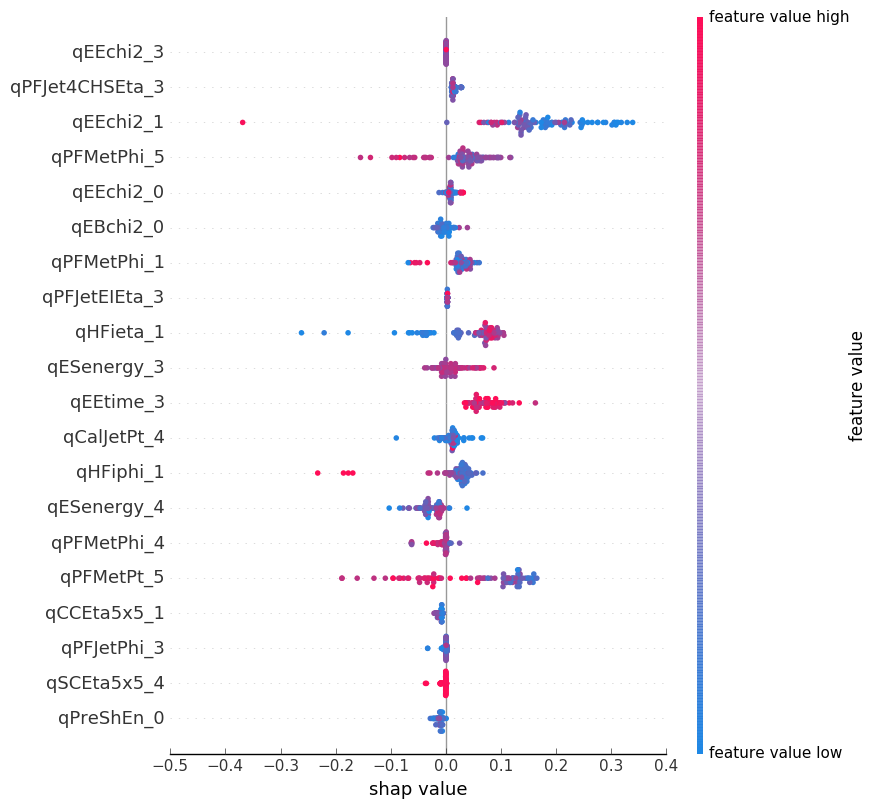

shap for channel for lumi
          PF      calo     muons       photons
0  -0.000933  0.000063  0.000027  3.051029e-04
1   0.000066 -0.000358 -0.000046 -6.448529e-04
2  -0.001168 -0.000350 -0.000372 -4.304374e-04
3  -0.001169 -0.000736  0.000057  9.083104e-07
4  -0.001454 -0.000379 -0.000027 -3.198154e-04
5  -0.000447 -0.000631 -0.000479  1.447731e-04
6   0.000140 -0.000631  0.000148 -3.815831e-05
7  -0.002122  0.000586 -0.000105 -6.479834e-04
8  -0.002096 -0.000529  0.000055  4.236579e-05
9  -0.002714 -0.000204 -0.000092 -4.722076e-04
10 -0.002819 -0.000069  0.000224 -5.339483e-04
11 -0.004745  0.001382 -0.000091 -7.791587e-04
12 -0.004788  0.002204  0.000185  8.265715e-06
13 -0.004538  0.001567 -0.000045 -2.267468e-05
14 -0.004655  0.002098  0.000068  3.073530e-04
15 -0.004963  0.001697  0.000277 -1.002856e-03
16 -0.001904  0.000217 -0.000015  1.102260e-04
17 -0.005144  0.001132 -0.000348 -4.935323e-04
18 -0.005275  0.001595  0.000075 -8.728633e-05
19 -0.005011  0.001424 -0.000116 -

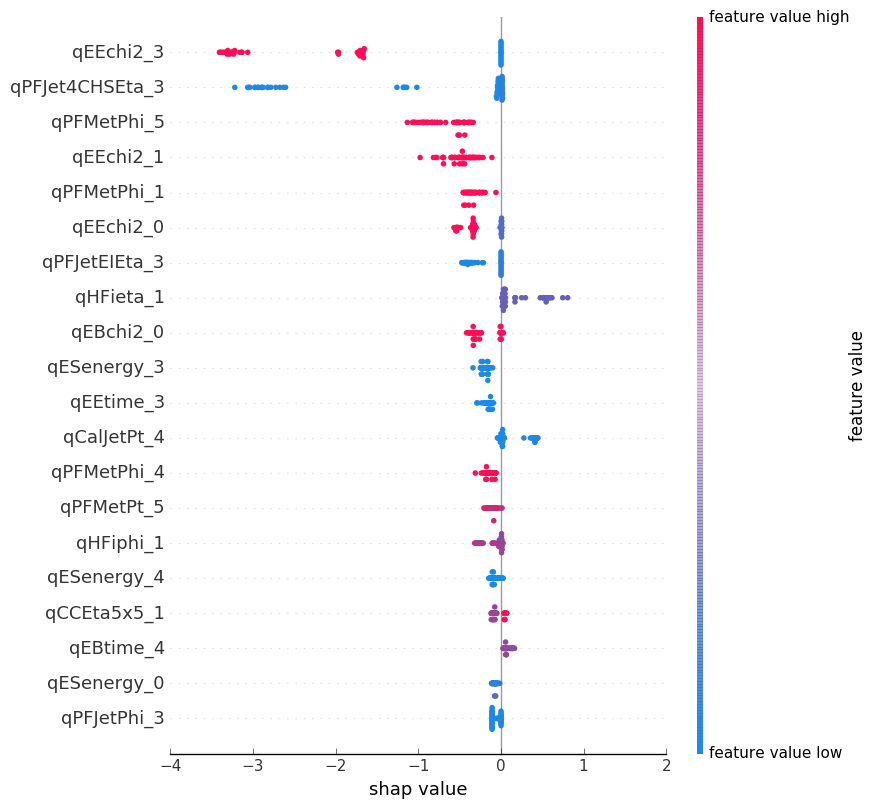

reference plot for good lumis


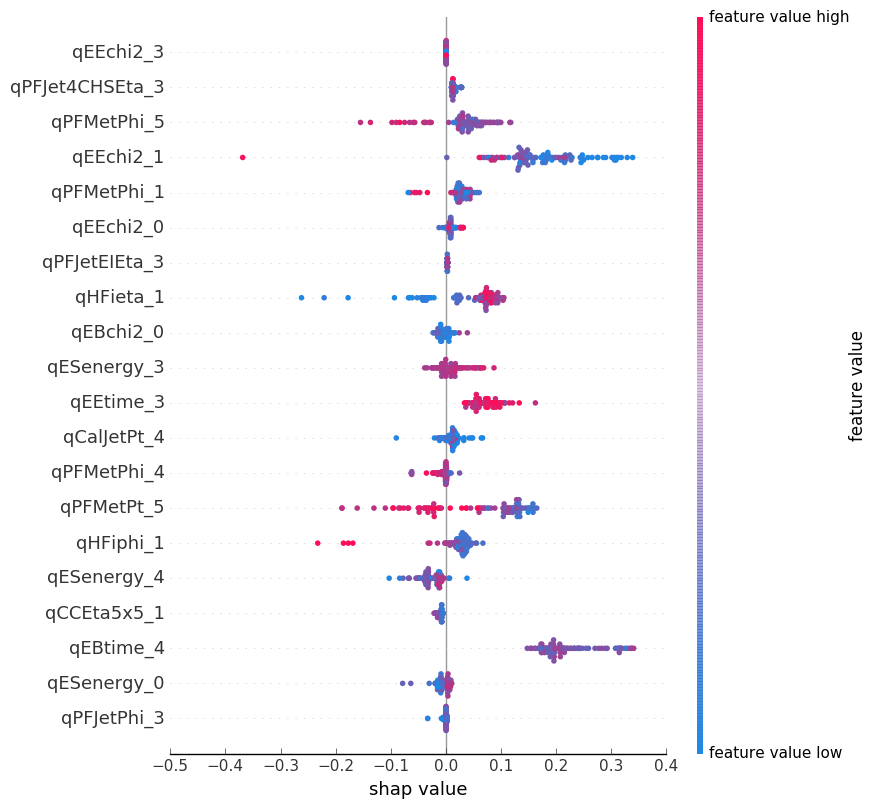

shap for channel for lumi
          PF      calo     muons   photons
0  -0.002241 -0.000250 -0.000305 -0.000284
1  -0.004957  0.001845 -0.000062 -0.000212
2  -0.001628 -0.000134  0.000039  0.000275
3  -0.002742  0.000448  0.000103 -0.000464
4  -0.004790  0.001885 -0.000149 -0.000766
5  -0.004990  0.001552 -0.000144 -0.000122
6  -0.002949  0.000326 -0.000104 -0.000273
7  -0.005196  0.001433 -0.000258 -0.000600
8  -0.002234 -0.000347 -0.000058 -0.000785
9  -0.002310  0.000142 -0.000016 -0.000537
10 -0.004540  0.001525 -0.000870 -0.000633
11 -0.002137 -0.000184  0.000264 -0.000609
12 -0.004297  0.001401 -0.000236 -0.000068
13 -0.004780  0.002001  0.000391 -0.000235
14 -0.004827  0.001942 -0.000375 -0.000629
15 -0.005120  0.001272 -0.000502 -0.000350
16 -0.005079  0.001732 -0.000131 -0.000344
17 -0.001993 -0.000362  0.000256 -0.000552
18 -0.004378  0.001622  0.000271  0.000472
19 -0.002106  0.000749 -0.000274 -0.000570
20 -0.004631  0.001654  0.000211 -0.000091
21 -0.001735  0.000590  0.00

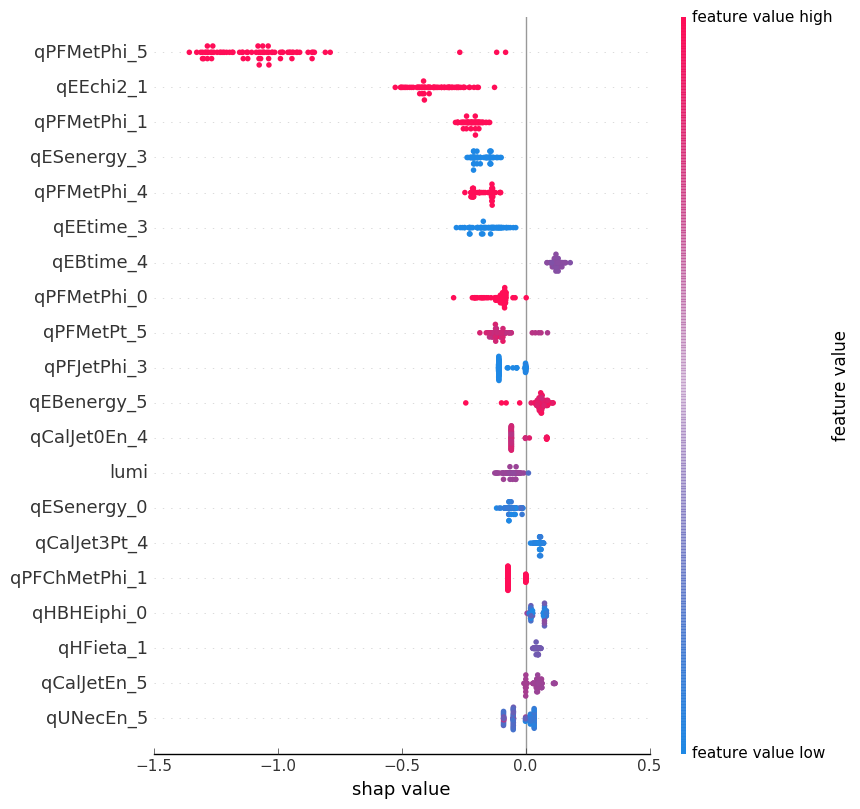

reference plot for good lumis


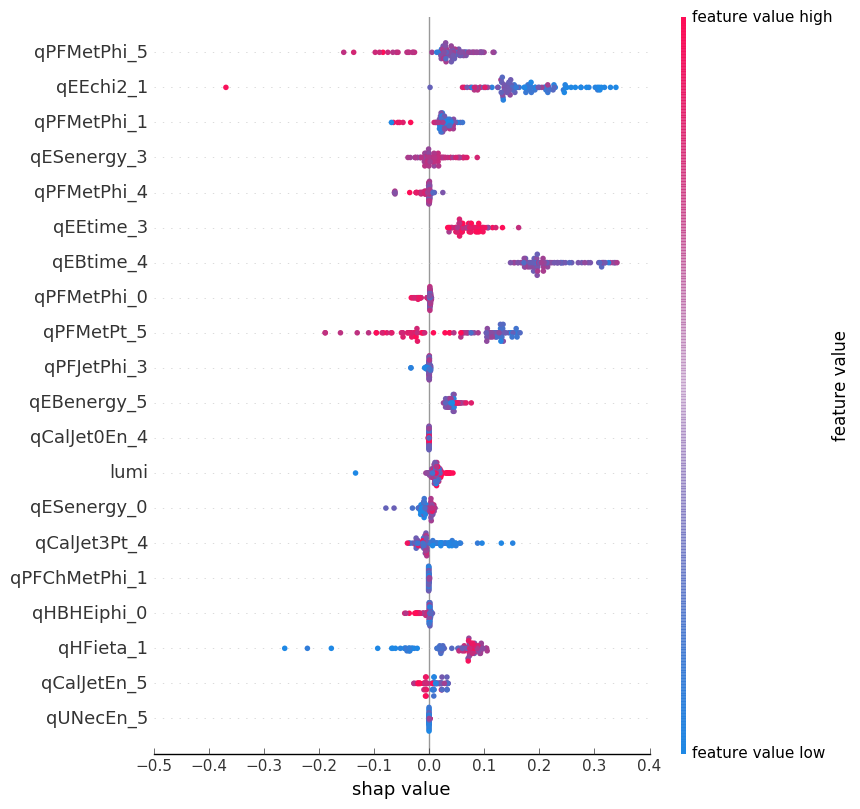

shap for channel for lumi
          PF      calo     muons   photons
0  -0.001563  0.000747  0.000043 -0.000287
1  -0.001432  0.000161 -0.000057  0.000275
2  -0.001121  0.000265  0.000182  0.000242
3  -0.001922 -0.000106  0.000240  0.000358
4  -0.001721  0.000124 -0.000077  0.000483
5  -0.002095  0.000018 -0.000065  0.000155
6  -0.001989  0.000528  0.000003  0.000507
7  -0.001493  0.000468  0.000119  0.000424
8  -0.001917  0.000820 -0.000022  0.000403
9  -0.001487  0.000928 -0.000327  0.000632
10 -0.001869  0.000158  0.000284  0.000413
11 -0.001947  0.000845  0.000116  0.000385
12 -0.001276 -0.000112 -0.000090 -0.000089
13 -0.000996  0.000271  0.000031  0.000375
14 -0.001346  0.000158  0.000042  0.000381
15 -0.001848  0.000664  0.000062  0.000500
16 -0.002127  0.000434  0.000075  0.000391
17 -0.001836 -0.000047  0.000170 -0.000514
18 -0.002299  0.000116  0.000055  0.000527
19 -0.000853 -0.000187 -0.000037  0.000146
20 -0.001787 -0.000569  0.000446  0.000213
21 -0.001848 -0.000109  0.00

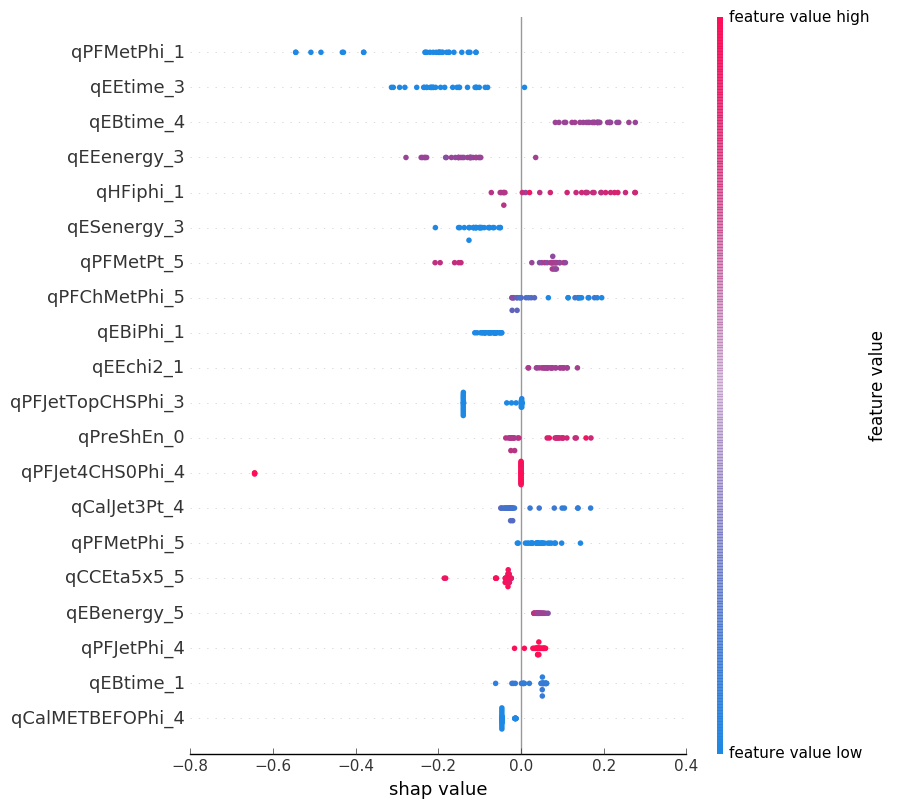

reference plot for good lumis


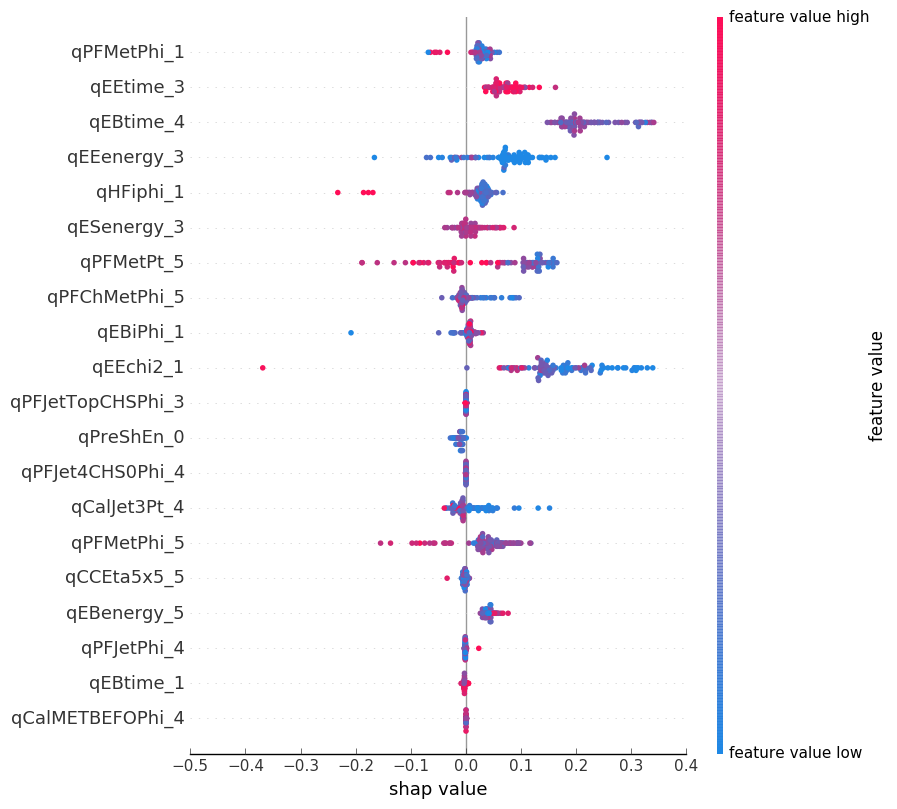

shap for channel for lumi
          PF      calo         muons   photons
0  -0.000801 -0.000925 -5.320194e-06 -0.000093
1  -0.001241 -0.000558  2.723344e-04 -0.000192
2  -0.001182 -0.000881  2.509181e-04  0.000075
3   0.000275  0.000419  8.722355e-05  0.000395
4   0.000224 -0.000441  2.805568e-04 -0.000048
5  -0.000366 -0.000087  2.406697e-04 -0.000342
6   0.000030 -0.001264  1.052117e-04  0.000109
7   0.000083 -0.000500  2.570417e-04 -0.000161
8  -0.000377  0.000062  1.098029e-04 -0.000010
9  -0.000009  0.000314 -2.597543e-05  0.000244
10  0.000155  0.000490 -1.477297e-04 -0.000217
11 -0.000179 -0.000284  3.344641e-04 -0.000156
12 -0.000022 -0.000984  8.619790e-05 -0.000288
13  0.000255 -0.000360  7.144160e-05  0.000345
14 -0.000665  0.000231  1.603744e-04 -0.000121
15  0.000391  0.000131  3.132582e-04  0.000087
16  0.000148 -0.000397  2.821776e-04  0.000080
17 -0.000256 -0.001014  2.486359e-07  0.000300
18  0.000119 -0.000130  1.698936e-04 -0.000156
19 -0.001090 -0.000480  2.576895e-

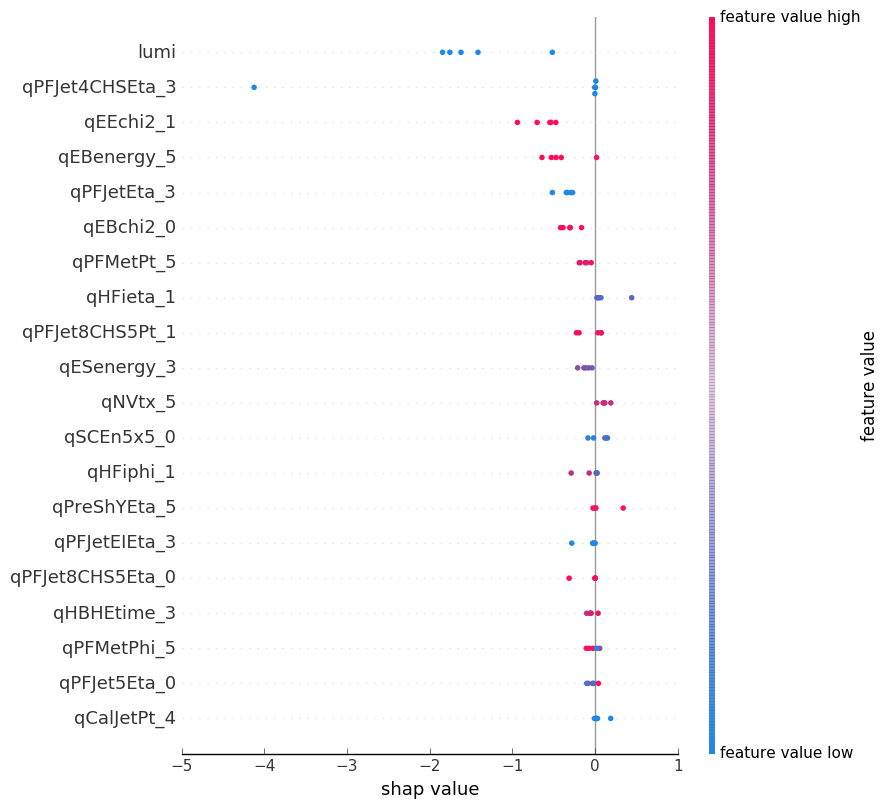

reference plot for good lumis


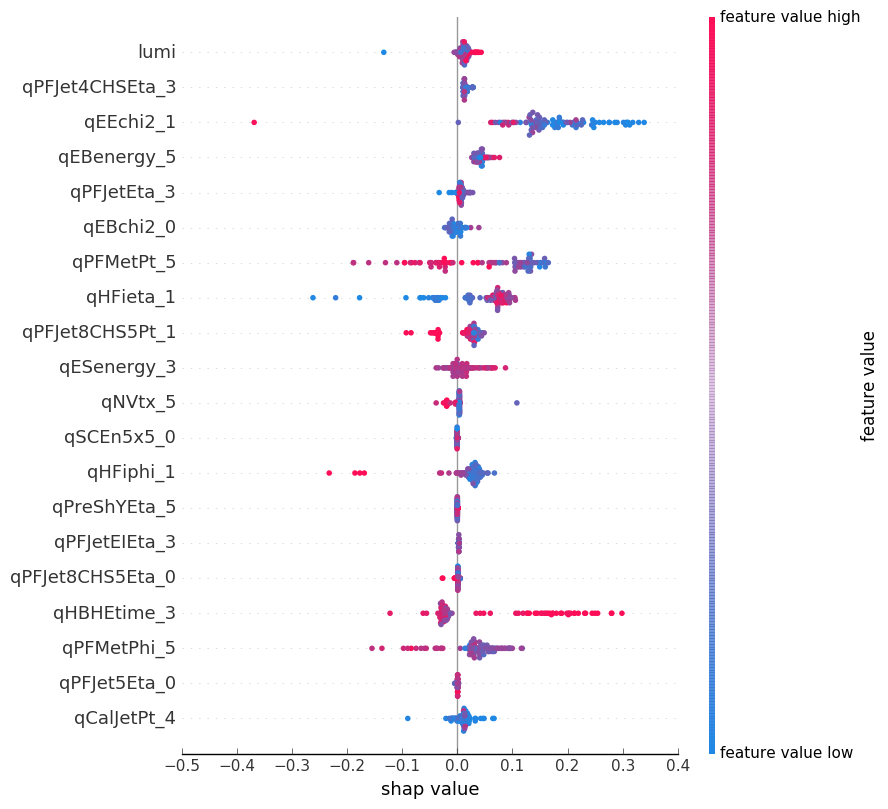

shap for channel for lumi
         PF      calo     muons   photons
0 -0.000902  0.000124 -0.000091 -0.000593
1 -0.001142  0.000294  0.000050 -0.000507
2 -0.001142 -0.000521 -0.000561 -0.000405
3 -0.000758  0.000363  0.000539  0.000316
4 -0.006053 -0.000776 -0.000465 -0.000748
 
shap for channel for run
PF        -0.009998
calo      -0.000516
muons     -0.000529
photons   -0.001938
dtype: float64
 
____________________________________________________________________________________________________
273296 is not found
282796 is not found
277933 is not found
280239 is not found
280241 is not found

(279995, ' [[1, 8]],  hcal water colling issues')

sum of features' influences from all lumis, 20 the most important

Index([u'qPFJet4CHSEta_3', u'qPFMetPt_5', u'qgedPhor2x5__1',
       u'qPFJet4CHSPhi_1', u'qEStime_1', u'qCalMETMEn_5', u'qPFMetPhi_3',
       u'qPFJetEIEta_3', u'qHFieta_1', u'qEEenergy_3', u'qPFJetEta_3',
       u'qNVtx_5', u'qPFJet4CHS3Phi_1', u'qEEenergy_5', u'qPFJet4CHS2Pt_

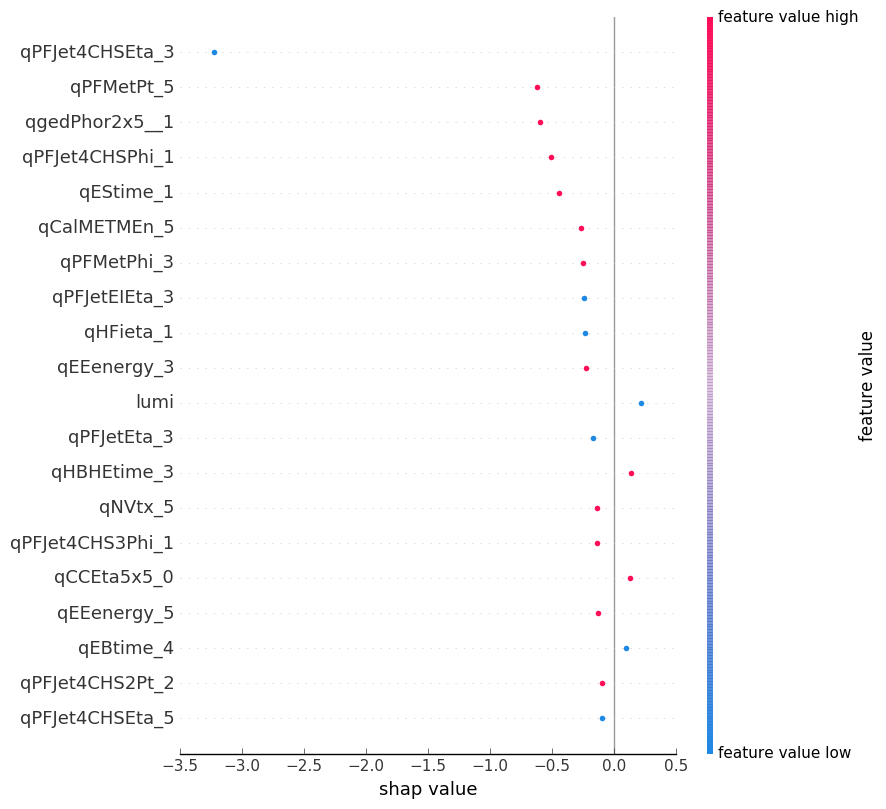

reference plot for good lumis


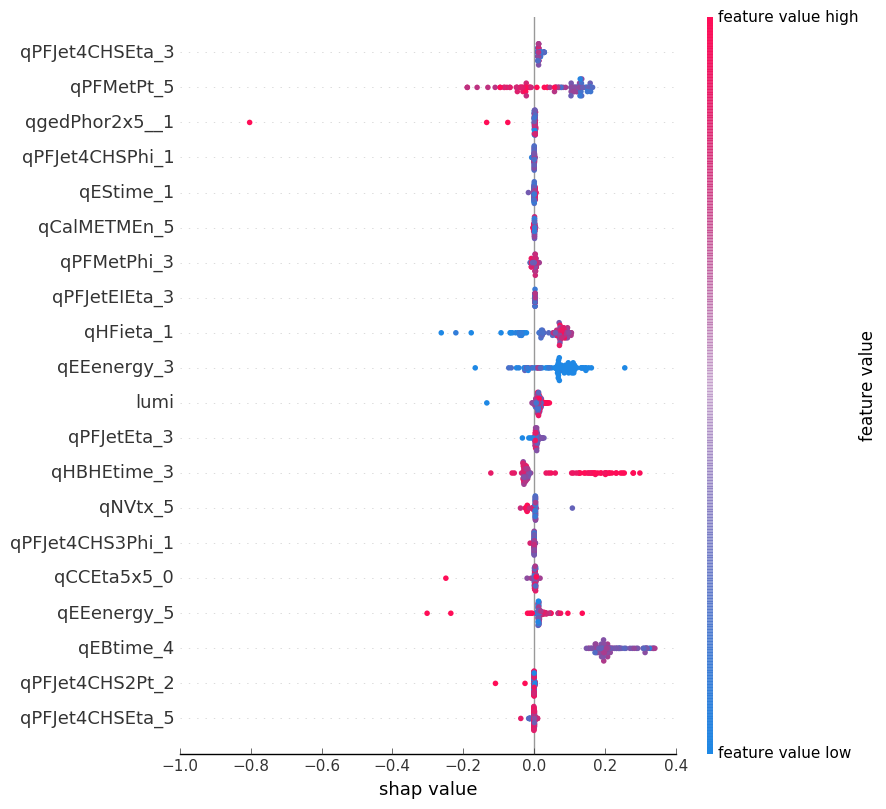

shap for channel for lumi
         PF      calo     muons  photons
0 -0.006691 -0.002853 -0.000428 -0.00099
 
shap for channel for run
PF        -0.006691
calo      -0.002853
muons     -0.000428
photons   -0.000990
dtype: float64
 
____________________________________________________________________________________________________
273445 is not found
280002 is not found

(280006, ' [[1, 68]],  EB-11 token ring missing')

sum of features' influences from all lumis, 20 the most important

Index([u'qCalMETBEFOPhi_1', u'qPFMetPhi_1', u'qCalMETPhi_3', u'qPFMetPhi_3',
       u'qPFMetPhi_5', u'qCalMETEn_4', u'qgedPhoPhi_1', u'qEBtime_0',
       u'qSCEn5x5_4', u'qESenergy_4', u'qPhosigmaeta__3', u'qPFJet8CHS0Eta_4',
       u'qPreShEn_5', u'qgedPho0Eta_5', u'qPFMetPt_0', u'qPFJet8CHSPt_1',
       u'qESenergy_5', u'qCCEta5x5_1', u'qPreShYEn_5', u'qPFMetPt_4'],
      dtype='object')

the most common features with big shap values

Index([u'qPFMetPhi_1', u'qPFMetPhi_3', u'qSCEn5x5_4', u'qPreShEn_5'

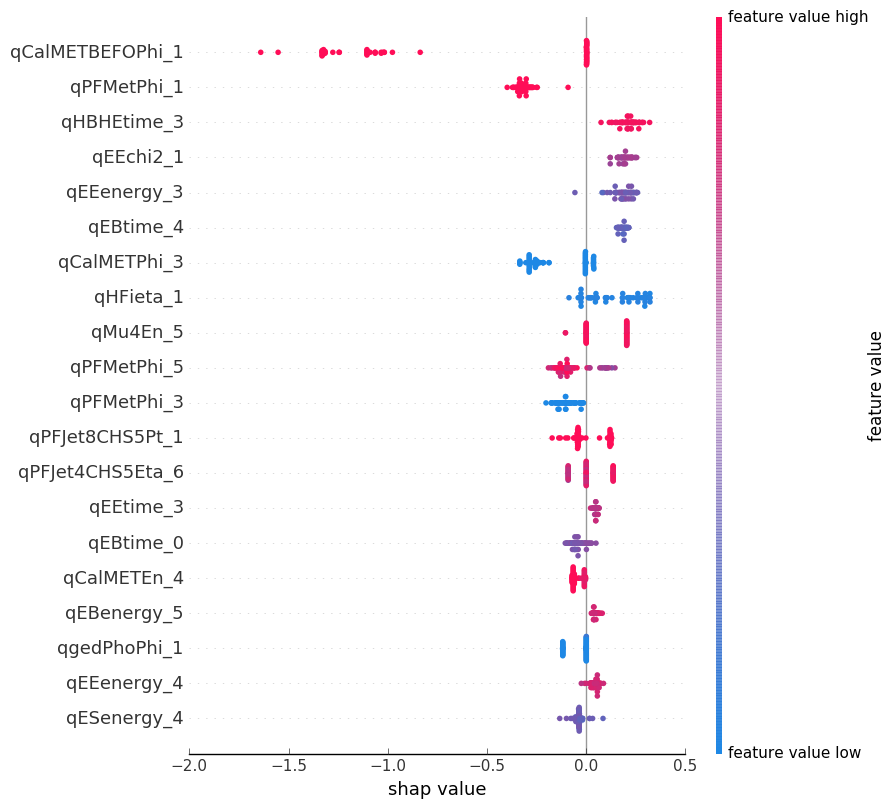

reference plot for good lumis


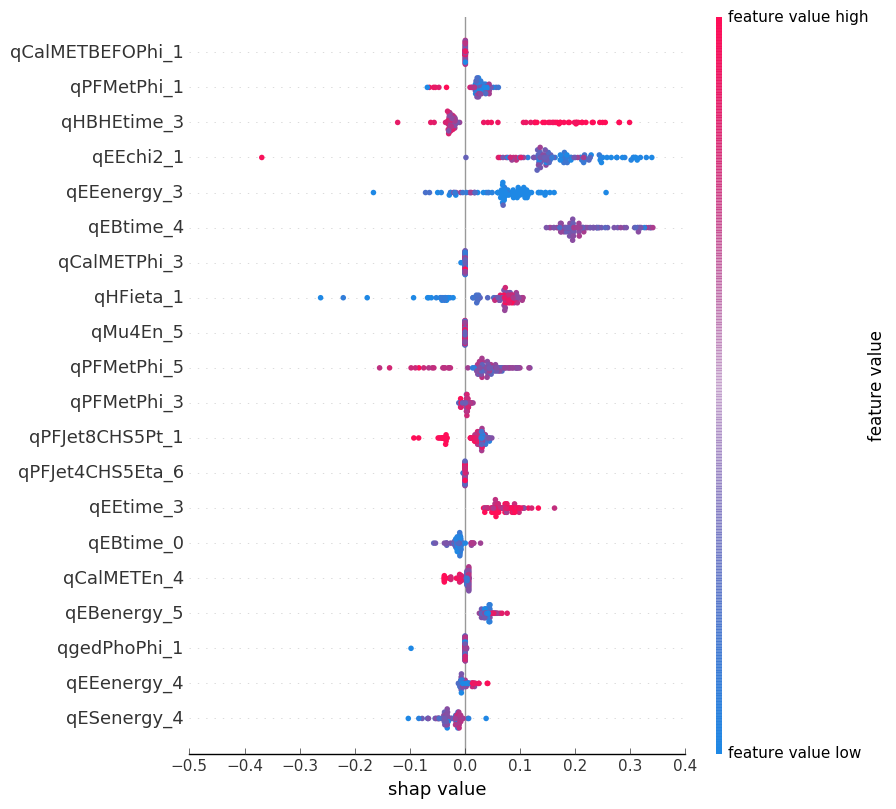

shap for channel for lumi
          PF          calo     muons       photons
0  -0.000028 -3.597893e-03  0.000659 -1.238716e-04
1  -0.000337 -4.303189e-03  0.000579  9.541683e-05
2  -0.000296  1.491182e-04  0.000002 -1.573623e-04
3  -0.000412 -4.608001e-03  0.000837 -2.715065e-04
4  -0.000631 -3.847228e-03  0.000565 -9.982572e-05
5  -0.000770 -5.690888e-03  0.000819 -2.505961e-05
6  -0.000664 -4.365352e-03  0.000757 -7.040532e-04
7  -0.000916 -5.270852e-03  0.000367 -1.301573e-04
8  -0.000240 -3.397774e-03  0.000842 -4.520137e-04
9  -0.000505 -5.161431e-03  0.000804  2.567742e-04
10 -0.000706 -4.835694e-03  0.000263 -6.476775e-04
11 -0.000676 -5.794688e-03  0.000453  1.559401e-04
12 -0.000775  2.713900e-04  0.000049 -3.251100e-04
13 -0.000230 -4.843772e-03  0.000716  2.038886e-04
14 -0.000851 -5.796085e-03 -0.000083 -1.219097e-04
15 -0.000754  1.709698e-04  0.000422 -1.157222e-04
16 -0.000596 -1.067964e-03 -0.000023 -3.643292e-04
17 -0.000798 -5.701038e-03  0.000537  9.246719e-07
18  0

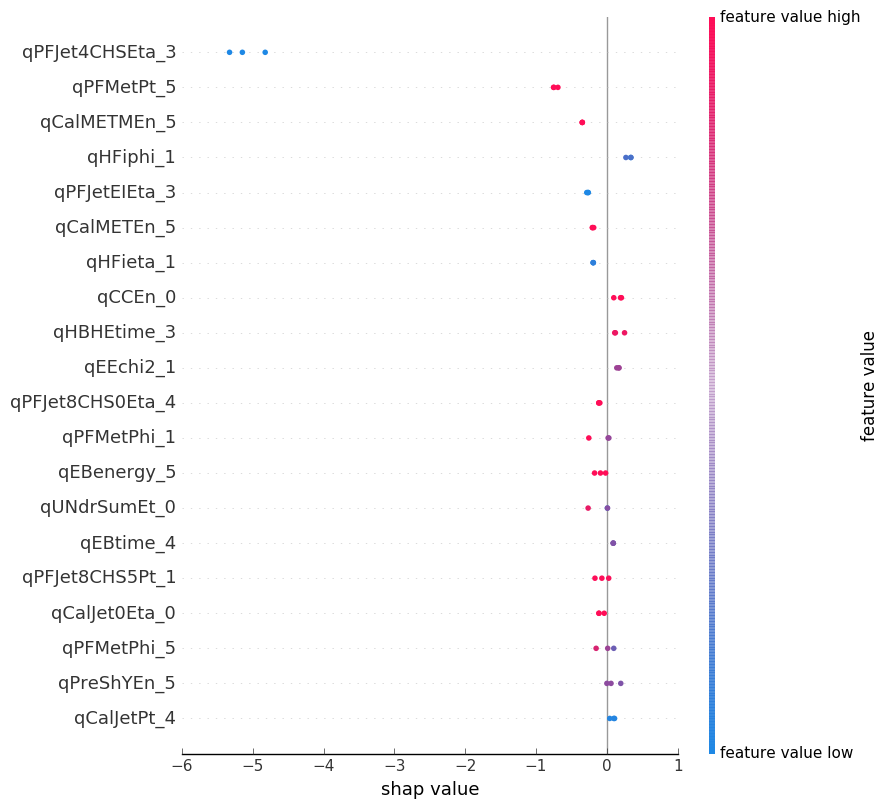

reference plot for good lumis


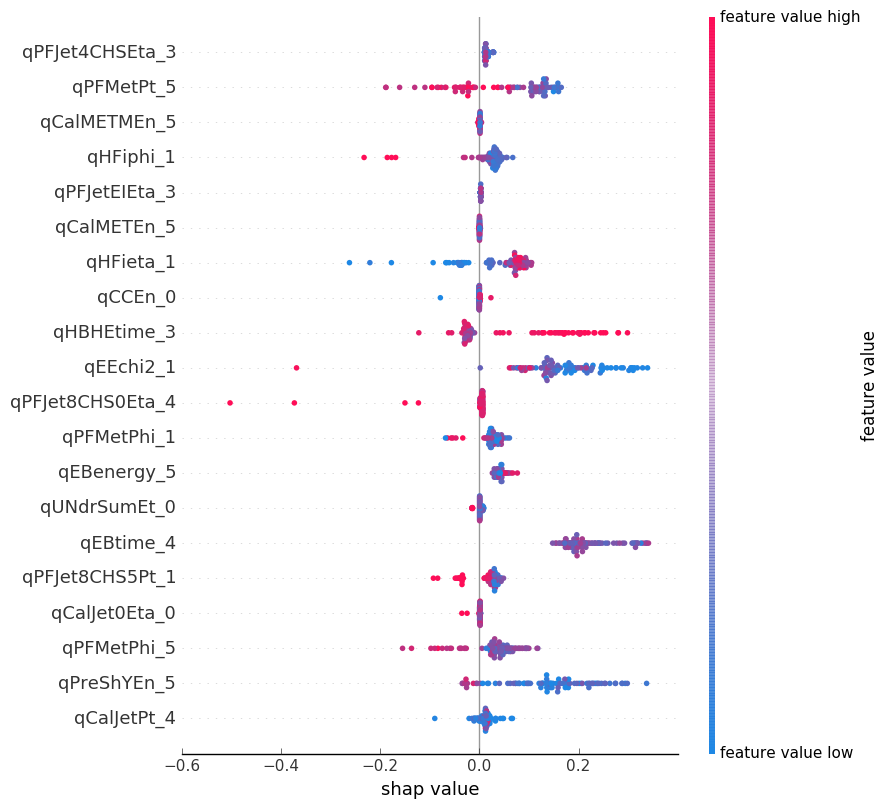

shap for channel for lumi
         PF      calo     muons   photons
0 -0.007196 -0.002203  0.000309 -0.000739
1 -0.007978 -0.002012  0.000198 -0.000635
2 -0.006090 -0.002896  0.000341 -0.001039
 
shap for channel for run
PF        -0.021264
calo      -0.007111
muons      0.000848
photons   -0.002413
dtype: float64
 
____________________________________________________________________________________________________

(275922, ' [[4, 6]],  low stat')

sum of features' influences from all lumis, 20 the most important

Index([u'qEEtime_3', u'qEBtime_4', u'qHFiphi_1', u'qESenergy_4',
       u'qESenergy_3', u'qEEenergy_3', u'qPreShYEn_4', u'qHBHEauxe_1',
       u'qPreShYEn_5', u'qCCEta5x5_5', u'qPFJet8CHSPt_4', u'lumi',
       u'qEEchi2_0', u'qHBHEtime_0', u'qPreShEn_4', u'qPFJetEI2Eta_1',
       u'qPreShEn_5', u'qCalJet2Phi_2', u'qHFieta_1', u'qPFJet8CHSSD4Eta_0'],
      dtype='object')

the most common features with big shap values

Index([u'qEBtime_4', u'qEEtime_3', u'qHFiphi_1', u'qESene

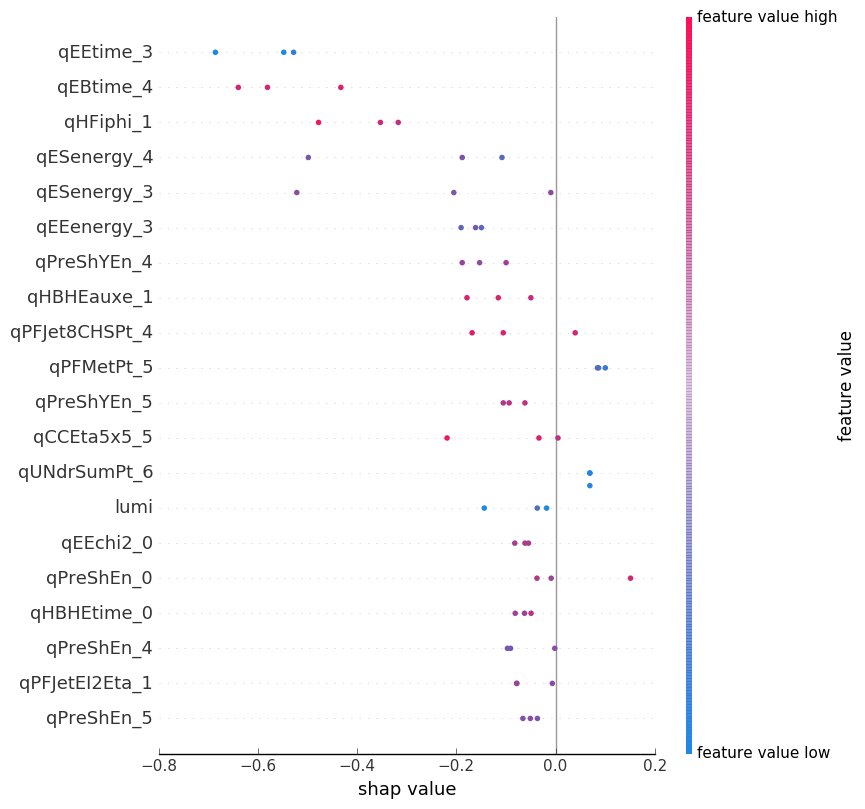

reference plot for good lumis


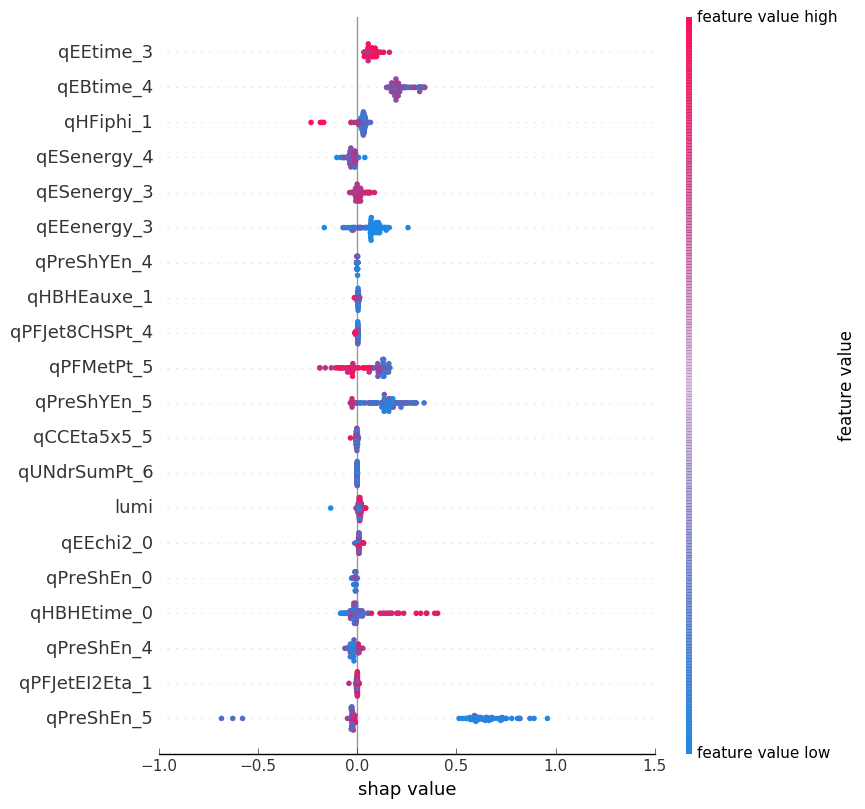

shap for channel for lumi
         PF      calo     muons   photons
0  0.000182 -0.000348  0.000112 -0.000188
1 -0.000381 -0.000029  0.000525  0.000043
2 -0.000219  0.000014  0.000624 -0.000134
 
shap for channel for run
PF        -0.000418
calo      -0.000363
muons      0.001261
photons   -0.000279
dtype: float64
 
____________________________________________________________________________________________________
274142 is not found

(278309, ' [[1, 10]],  EE-04 FED 607 TT disabled in LS [1-10] according to express dataset (LS# 10)')

sum of features' influences from all lumis, 20 the most important

Index([u'qCCPhi5x5_0', u'qCCPhi5x5_5', u'qCCEta5x5_4', u'qCCEta5x5_0',
       u'qCCEn5x5_5', u'qCalJet1Pt_4', u'qPFMetPhi_1', u'qEEenergy_3',
       u'qCCEta5x5_5', u'qEEix_4', u'qESenergy_4', u'qHBHEtime_0',
       u'qEBtime_3', u'qEEiy_0', u'qPFJet4CHSEta_5', u'qPreShEn_4',
       u'qSCEta5x5_4', u'qPFJet8CHS1Eta_1', u'qPreShEn_5',
       u'qCalMETBEFOPhi_3'],
      dtype='object')

th

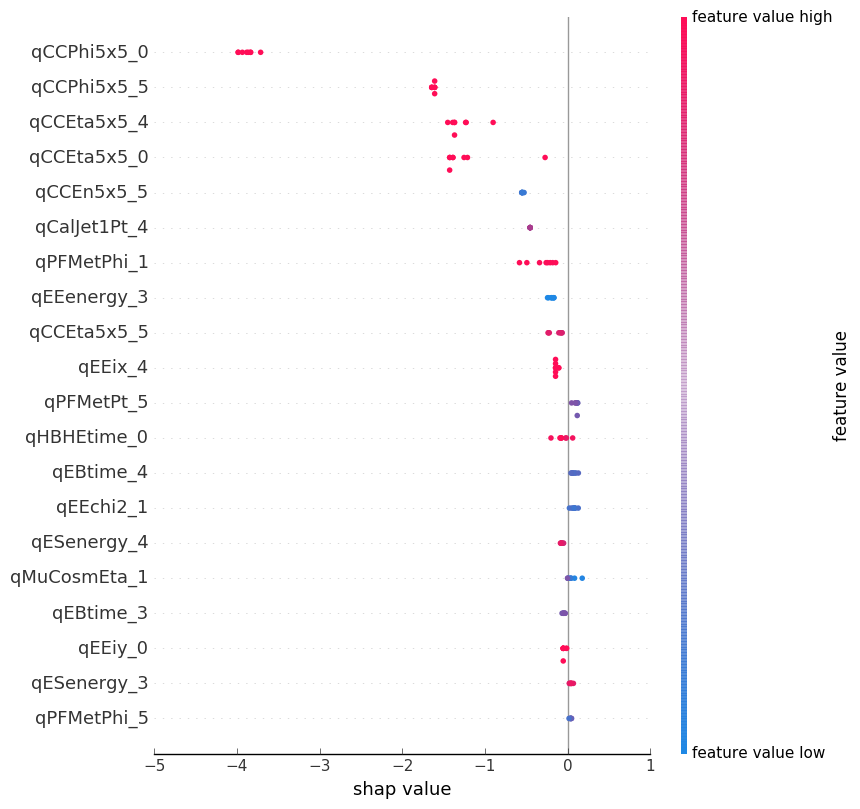

reference plot for good lumis


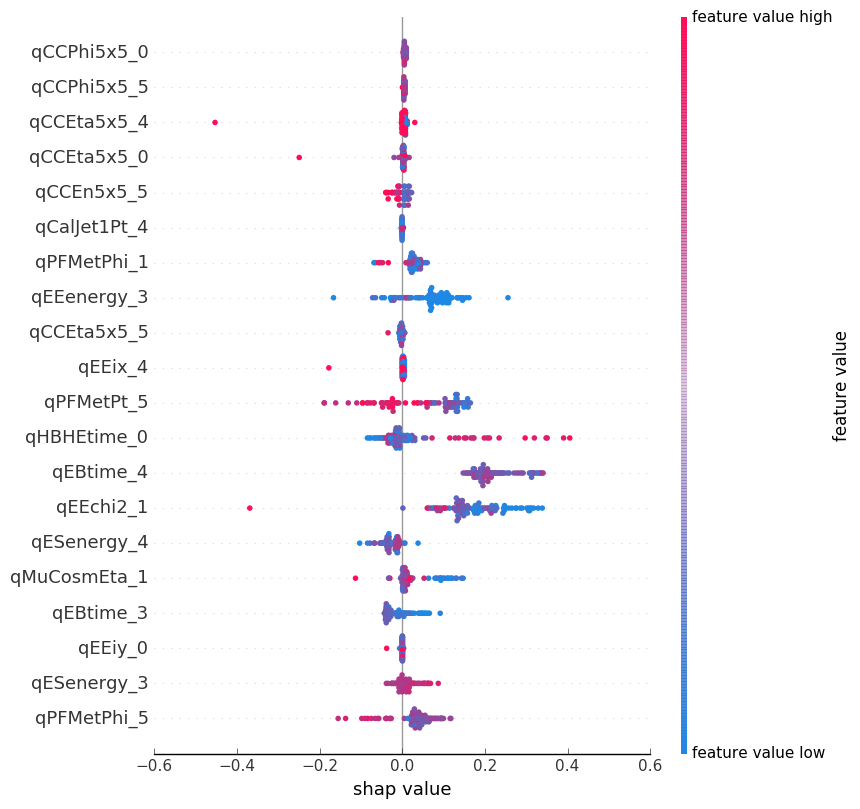

shap for channel for lumi
         PF      calo     muons   photons
0  0.000019 -0.001586  0.000476  0.000121
1 -0.000576 -0.002041  0.000353 -0.000117
2  0.000034 -0.001599  0.000346  0.000016
3  0.000130 -0.002460  0.000218  0.000103
4 -0.000561 -0.002080  0.000200 -0.000081
5 -0.000358 -0.001944 -0.000324  0.000008
6  0.000044 -0.001894  0.000677 -0.000034
7 -0.000164 -0.002007  0.000440 -0.000081
 
shap for channel for run
PF        -0.001430
calo      -0.015612
muons      0.002386
photons   -0.000065
dtype: float64
 
____________________________________________________________________________________________________
277217 is not found

(276453, ' [[1, 8], [10, 125]],  EB-17 (FED 626): was excluded (because of cooling failure)')

sum of features' influences from all lumis, 20 the most important

Index([u'qSCEtaWidth_0', u'qEBiPhi_1', u'qEEenergy_3', u'qEBenergy_5',
       u'qgedPhoEta_1', u'qPFMetPhi_1', u'qSCPhiWidth_5', u'qHBHEtime_5',
       u'qPFJet8CHSEta_3', u'qCalJet2Pt_5',

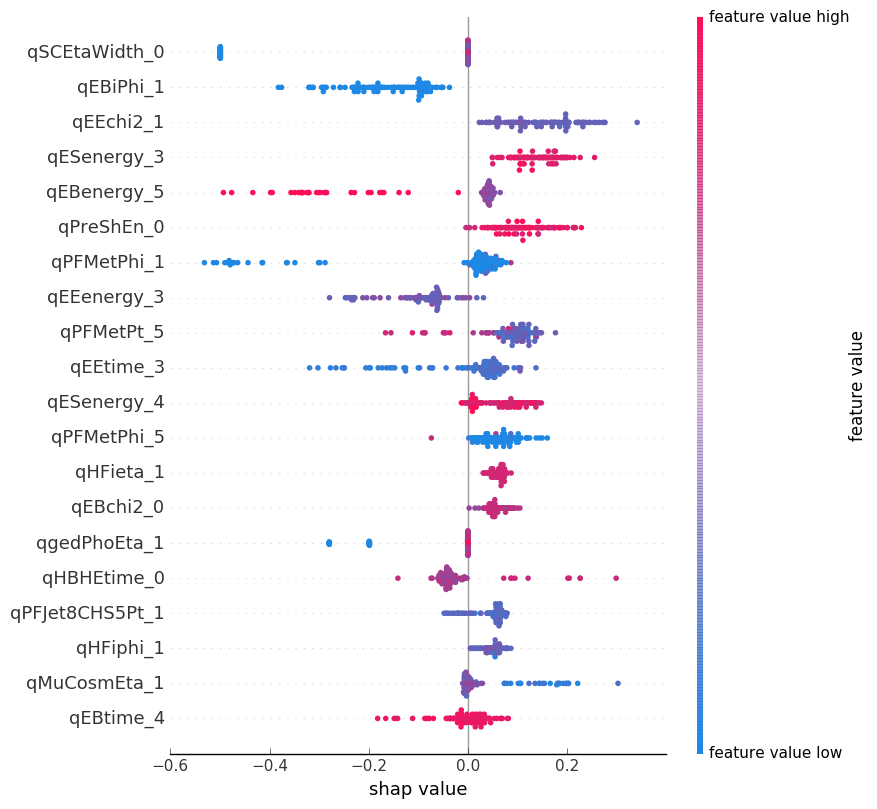

reference plot for good lumis


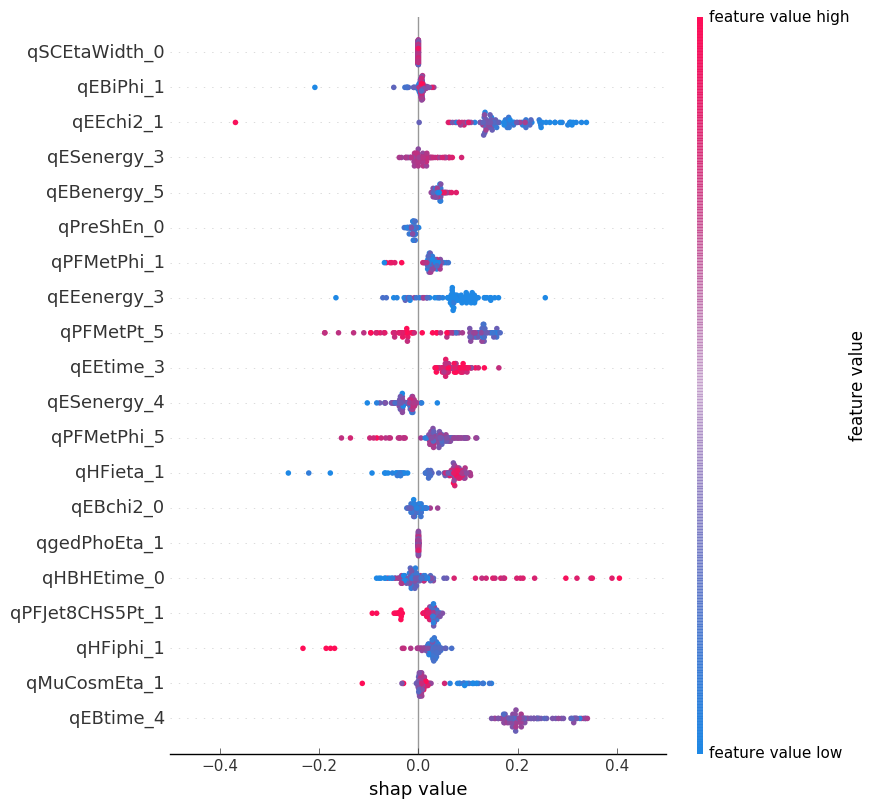

shap for channel for lumi
           PF      calo     muons   photons
0    0.000306 -0.000211  0.000008 -0.000259
1   -0.000059 -0.000088  0.000178  0.000346
2    0.000374 -0.000120  0.000129  0.000265
3    0.000590 -0.000097  0.000111 -0.000039
4    0.000330  0.000163  0.000086 -0.000449
5    0.000353 -0.000313  0.000273 -0.000327
6    0.000431 -0.000186  0.000713  0.000152
7   -0.000596 -0.000257  0.000907 -0.001035
8   -0.000181 -0.000618  0.000705 -0.000335
9   -0.000075 -0.000490 -0.000173 -0.000416
10  -0.000025  0.000179  0.000351 -0.000457
11   0.000115  0.000140  0.000332 -0.000722
12  -0.000188 -0.000147  0.000116 -0.000501
13  -0.000287  0.000297  0.000659 -0.000946
14  -0.000131 -0.000562  0.000715 -0.000780
15   0.000050 -0.000387  0.000012 -0.000881
16  -0.000543 -0.000305  0.000415 -0.000387
17  -0.000209  0.000158  0.000210 -0.000670
18   0.000143  0.000059 -0.000184 -0.000592
19  -0.000115  0.000324  0.000660 -0.000829
20   0.000347  0.000049  0.000856 -0.000950
21   0

In [70]:
for run in dict_causes.keys():
    if run in sublabels['runId'].values:
        print('')
        print (run, dict_causes[run])
        print('')
            
        inds = np.where(np.array(ids_known)==run)[0]

        print ("sum of features' influences from all lumis, 20 the most important")
        print('')
        sum_shap = np.sum(shap_values[inds,:-1], axis=0)
        print (feature_names[np.argsort(sum_shap, axis=0)][:20])
        print('')
        
        print("the most common features with big shap values")
        print('')
        top_sh_values = np.argsort(shap_values[inds,:-1], axis=1)[:,:50].T.reshape(-1)
        unique, first_index, counts = np.unique(
            top_sh_values,
        return_counts=True, return_index=True)
        print(feature_names[top_sh_values[np.sort(first_index[counts == len(inds)])]])
        print('')
        
        print ('summary plot')
        order=summary_plot_custom(shap_values[inds,:], features=X_known[inds, :], feature_names=feature_names,
                               vmins=vmins, vmaxs=vmaxs, return_oder=True, sort=True)
        
        print ('reference plot for good lumis')
        summary_plot_custom(shap_ref[:,order], features=X_ref[:,order], feature_names=feature_names[order],
                               vmins=vmins[order], vmaxs=vmaxs[order], return_oder=False, sort=False)
        
        channels_shap = pd.DataFrame()
        for i in shap_values[inds,:-1]:
            pred_for_channnel = {}
            for channel in channels_features:
                current_sum = 0
                for feature in channels_features[channel]:
                    current_sum += i[list(feature_names).index(feature)]
                pred_for_channnel[channel] = current_sum/num_fch[channel]
            channels_shap = channels_shap.append(pred_for_channnel, ignore_index=True)

        print ('shap for channel for lumi')
        print (channels_shap)
        print(" ")
        
        print ('shap for channel for run')
        print(channels_shap.sum())
        print(" ")
        print("_"*100)
        
    else:
        print (str(run) +' is not found')

In [64]:
sublabels[sublabels["runId"]==279995]

,runId,lumiId,isSig,Csc,Dt,Ecal,Egamma,Es,Hcal,Hlt,Jetmet,L1tcalo,L1tmu,Lumi,Muon,Pix,Rpc,Strip,Track,new_json
108963,279995,8,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0.0
